<a href="https://colab.research.google.com/github/oujianjiu/12919712/blob/master/Assignment_2_Thoracic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run the code, u need to download the dataset from github.

# Data Load


In [1]:
#Load and shuffle data
import pandas as pd
from google.colab import drive
import numpy as np
import sklearn.model_selection as ms
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score
from imblearn.over_sampling import SMOTE

drive.mount('/content/gdrive')
dataDir = 'gdrive/My Drive/ML_A2/Thoracic Surgery.xlsx'  #change dir to your project folder
xlsfile=pd.ExcelFile(dataDir)
df=xlsfile.parse('in')
from sklearn.utils import shuffle
df = shuffle(df)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import and frame dataset with One_hot_Encoding

In [0]:
Col2Dummy = ['DGN',	'PRE6','PRE7','PRE8','PRE9',	'PRE10',	'PRE11',	'PRE14'	,'PRE17'	,'PRE19',	'PRE25'	,'PRE30',	'PRE32']

In [0]:
def DummyCol(frame,column):
  pf = pd.get_dummies(frame[[column]])
  frame = pd.concat([frame, pf], axis=1)
  frame.drop([column], axis=1, inplace=True)
  return frame

In [0]:
for i in Col2Dummy:
  df = DummyCol(df,i)

In [5]:
df.head()

,PRE4,PRE5,AGE,Risk1Yr,DGN_DGN1,DGN_DGN2,DGN_DGN3,DGN_DGN4,DGN_DGN5,DGN_DGN6,DGN_DGN8,PRE6_PRZ0,PRE6_PRZ1,PRE6_PRZ2,PRE7_F,PRE7_T,PRE8_F,PRE8_T,PRE9_F,PRE9_T,PRE10_F,PRE10_T,PRE11_F,PRE11_T,PRE14_OC11,PRE14_OC12,PRE14_OC13,PRE14_OC14,PRE17_F,PRE17_T,PRE19_F,PRE19_T,PRE25_F,PRE25_T,PRE30_F,PRE30_T,PRE32_F,PRE32_T
408,3.08,2.24,59,F,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,1,1,0
113,4.68,3.48,52,F,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0
316,3.60,2.64,57,F,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0
153,3.44,3.13,78,F,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,1,0
243,4.36,3.92,47,F,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0


In [0]:
for i in df.head():
  if i=='Risk1Yr':
    df[i]=df[i].astype('category')
    df[i] =df[i].cat.codes

In [7]:
#split the label(target)
Y = df.loc[ : , 'Risk1Yr' ]
X=df.iloc[:, df.columns != 'Risk1Yr']

import numpy as np
X = X.as_matrix()
Y = Y.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# Import SMOTE to OverSampling the Training  set

In [0]:
#SMOTE
from imblearn.over_sampling import SMOTE
xTrain,xTest,yTrain,yTest=ms.train_test_split(X,Y,test_size=0.3)

sm = SMOTE(random_state=66, ratio=1,k_neighbors=5)
xTrain, yTrain = sm.fit_sample(xTrain, yTrain)
#xTrain,xVal,yTrain,yVal=ms.train_test_split(xTrain, yTrain,test_size=0.1)

# Train Test and Random Forest (With SMOTE)

In [9]:
from sklearn.ensemble import RandomForestClassifier

RSEED = 50
# Create the model with 100 trees
#why is number of estimators not 999?
model = RandomForestClassifier(n_estimators=6, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1,criterion='entropy')
# Fit on training data
model.fit(xTrain, yTrain)
#
importances = model.feature_importances_

n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Average number of nodes 167
Average maximum depth 19


In [10]:
# Testing predictions (to determine performance)
rf_predictions_NoOS = model.predict(xTest)
rf_probs_NoOS = model.predict_proba(xTest)[:, 1]

#rf_predictions_WithOS = model.predict(xVal)
#rf_probs_WithOS = model.predict_proba(xVal)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished


# AUROC Graph

In [0]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(yTest, 
                                     [1 for _ in range(len(yTest))])
    baseline['precision'] = precision_score(yTest, 
                                      [1 for _ in range(len(yTest))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(yTest, predictions)
    results['precision'] = precision_score(yTest, predictions)
    results['roc'] = roc_auc_score(yTest, probs)
    
    
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(yTest, [1 for _ in range(len(yTest))])
    model_fpr, model_tpr, _ = roc_curve(yTest, probs)

    plt.figure(figsize = (10, 10))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

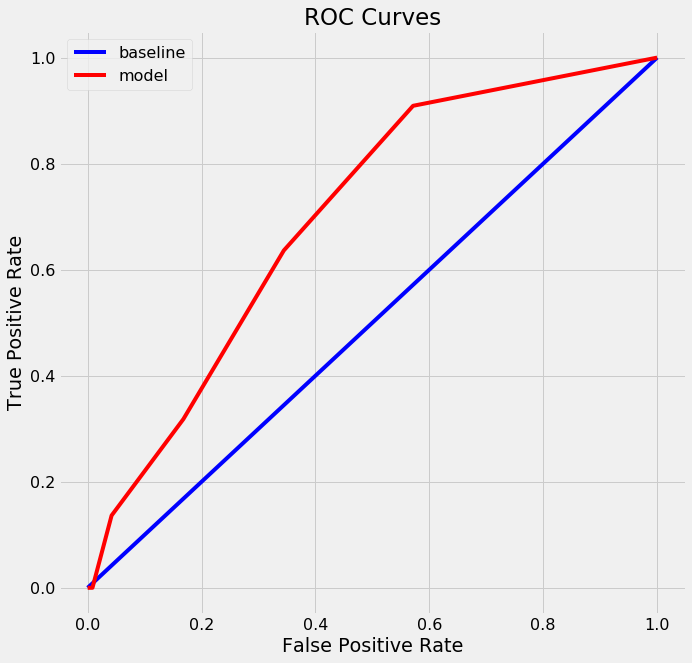

In [12]:
evaluate_model(rf_predictions_NoOS, rf_probs_NoOS)
#evaluate_model(rf_predictions_WithOS, rf_probs_WithOS)

# confusion_matrix Diagram

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)



Confusion matrix, without normalization
[[114   5]
 [ 19   3]]


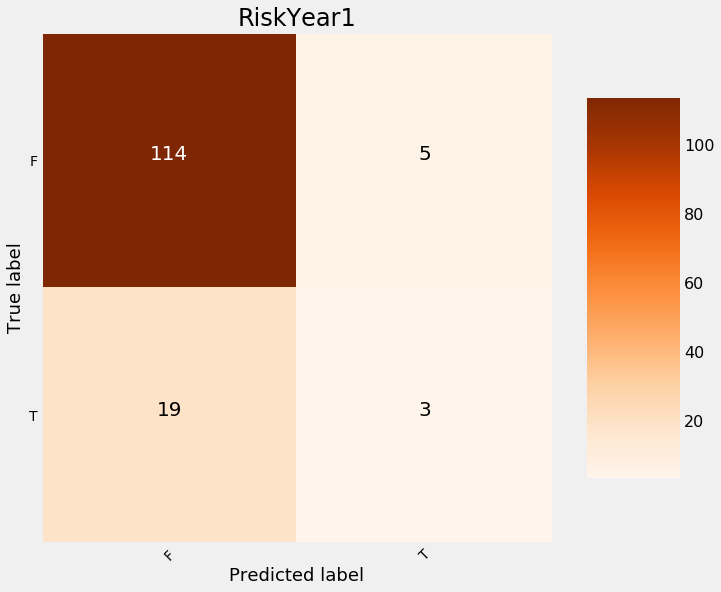

In [14]:
# Confusion matrix
cm_NoOS = confusion_matrix(yTest, rf_predictions_NoOS)
plot_confusion_matrix(cm_NoOS, classes = ['F', 'T'],
                      title = 'RiskYear1')

In [15]:
from sklearn.metrics import classification_report
print(classification_report(yTest, rf_predictions_NoOS))


              precision    recall  f1-score   support

           0       0.86      0.96      0.90       119
           1       0.38      0.14      0.20        22

    accuracy                           0.83       141
   macro avg       0.62      0.55      0.55       141
weighted avg       0.78      0.83      0.79       141



# Random Forest (with overSampling)

In [16]:
#here will take a while to train
from statistics import mean
from statistics import median
from sklearn.metrics import f1_score,accuracy_score,recall_score
tot_f1_1=[]
tot_f1_0=[]
tot_accs=[]
tot_recs_1=[]
for i in range (0,200):
  scores_1 = []
  scores_0 = []
  recs_1=[]
  accs=[]
  sm = SMOTE(random_state=66, ratio=1,k_neighbors=5)
  xTrainNew,xTestNew,yTrainNew,yTestNew=ms.train_test_split(X,Y,test_size=0.3)
  xTrainNew, yTrainNew = sm.fit_sample(xTrainNew, yTrainNew)

  RFmodel = RandomForestClassifier(n_estimators=6, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1,criterion='entropy')

  kfmodel=RFmodel.fit(xTrainNew, yTrainNew)
  kpred=kfmodel.predict(xTestNew)
  scores_1.append(f1_score(yTestNew, kpred, labels=None, pos_label=1,sample_weight=None))
  scores_0.append(f1_score(yTestNew, kpred, labels=None, pos_label=0,sample_weight=None))
  accs.append(accuracy_score(yTestNew, kpred))
  recs_1.append(recall_score(yTestNew, kpred, labels=None, pos_label=1,sample_weight=None))
tot_f1_1.append(mean(scores_1))
tot_f1_0.append(mean(scores_0))
tot_accs.append(mean(accs))
tot_recs_1.append(mean( recs_1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_j

In [17]:
from statistics import mean
from statistics import median
print('f1 avg_T: ',mean(tot_f1_1))
print('f1 avg_F: ',mean(tot_f1_0))
print('acc avg: ',mean(tot_accs))
print('rec avg_T: ',mean(tot_recs_1))

f1 avg_T:  0.2962962962962963
f1 avg_F:  0.9254901960784314
acc avg:  0.8652482269503546
rec avg_T:  0.25


# Random Forest (withOut overSampling)

In [18]:
from statistics import mean
from statistics import median
#here will take a while to train
tot_f1_1=[]
tot_f1_0=[]
tot_accs=[]
tot_recs_1=[]
for i in range (0,200):
  scores_1 = []
  scores_0 = []
  recs_1=[]
  accs=[]
  #sm = SMOTE(random_state=66, ratio=1,k_neighbors=5)
  xTrainNew,xTestNew,yTrainNew,yTestNew=ms.train_test_split(X,Y,test_size=0.3)
 # xTrainNew, yTrainNew = sm.fit_sample(xTrainNew, yTrainNew)

  RFmodel = RandomForestClassifier(n_estimators=6, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1,criterion='entropy')

  kfmodel=RFmodel.fit(xTrainNew, yTrainNew)
  kpred=kfmodel.predict(xTestNew)
  scores_1.append(f1_score(yTestNew, kpred, labels=None, pos_label=1,sample_weight=None))
  scores_0.append(f1_score(yTestNew, kpred, labels=None, pos_label=0,sample_weight=None))
  accs.append(accuracy_score(yTestNew, kpred))
  recs_1.append(recall_score(yTestNew, kpred, labels=None, pos_label=1,sample_weight=None))
tot_f1_1.append(mean(scores_1))
tot_f1_0.append(mean(scores_0))
tot_accs.append(mean(accs))
tot_recs_1.append(mean( recs_1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_j

In [19]:
from statistics import mean
from statistics import median
print('f1 avg_T: ',mean(tot_f1_1))
print('f1 avg_F: ',mean(tot_f1_0))
print('acc avg: ',mean(tot_accs))
print('rec avg_T: ',mean(tot_recs_1))


f1 avg_T:  0.0
f1 avg_F:  0.9277566539923955
acc avg:  0.8652482269503546
rec avg_T:  0.0


In [20]:
from sklearn.metrics import classification_report
print(classification_report(yTestNew, kpred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       123
           1       0.00      0.00      0.00        18

    accuracy                           0.87       141
   macro avg       0.44      0.50      0.46       141
weighted avg       0.76      0.87      0.81       141



# Decision Tree (No overSampling)

In [0]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,accuracy_score
tot_f1_1=[]
tot_f1_0=[]
tot_accs=[]
tot_recs_1=[]
for i in range (0,200):
  scores_1 = []
  scores_0 = []
  accs=[]
  recs_1=[]
  clf = DecisionTreeClassifier(criterion='entropy',max_depth=30,random_state=20)  #2 main methods:gini and entropy
  xTrainNew,xTestNew,yTrainNew,yTestNew=ms.train_test_split(X,Y,test_size=0.3)
  cv = KFold(n_splits=2, random_state=10, shuffle=True)
  #for train_index, test_index in cv.split(X):
      #print("Train Index: ", train_index, "\n")
      #print("Test Index: ", test_index)

      #X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
  kfmodel=clf.fit(xTrainNew, yTrainNew)
  kpred=kfmodel.predict(xTestNew)
      #kpred_OS=kfmodel.predict(xVal)#xTest
      #cm = confusion_matrix(y_test, kpred)
      #plot_confusion_matrix(cm, classes = ['F', 'T'],
                        #title = 'RiskYear1')
      #print(classification_report(yValTest, kpred))
      #print(classification_report(yVal, kpred))
  scores_1.append(f1_score(yTestNew, kpred, labels=None, pos_label=1,sample_weight=None))
  scores_0.append(f1_score(yTestNew, kpred, labels=None, pos_label=0,sample_weight=None))
  accs.append(accuracy_score(yTestNew, kpred))
  recs_1.append(recall_score(yTestNew, kpred, labels=None, pos_label=1,sample_weight=None))
tot_f1_1.append(mean(scores_1))
tot_f1_0.append(mean(scores_0))
tot_accs.append(mean(accs))
tot_recs_1.append(mean( recs_1))

In [22]:
from statistics import mean
from statistics import median
print('f1 avg_T: ',mean(tot_f1_1))
print('f1 avg_F: ',mean(tot_f1_0))
print('acc avg: ',mean(tot_accs))
print('rec avg_T: ',mean(tot_recs_1))

f1 avg_T:  0.20512820512820512
f1 avg_F:  0.8724279835390946
acc avg:  0.7801418439716312
rec avg_T:  0.25


In [23]:
from sklearn.metrics import classification_report
print(classification_report(yTestNew, kpred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       125
           1       0.17      0.25      0.21        16

    accuracy                           0.78       141
   macro avg       0.54      0.55      0.54       141
weighted avg       0.82      0.78      0.80       141



# Decision Tree (With overSampling)

In [0]:
#here will take a while to train
tot_f1_1=[]
tot_f1_0=[]
tot_accs=[]
tot_recs_1=[]
for i in range (0,200):
  scores_1 = []
  scores_0 = []
  accs=[]
  recs_1=[]
  sm = SMOTE(random_state=66, ratio=1,k_neighbors=5)
  xTrainNew,xTestNew,yTrainNew,yTestNew=ms.train_test_split(X,Y,test_size=0.3)
  xTrainNew, yTrainNew = sm.fit_sample(xTrainNew, yTrainNew)

  clf_OS = DecisionTreeClassifier(criterion='entropy',max_depth=30,random_state=20)  #2 main methods:gini and entropy

  #cv01 = KFold(n_splits=5, random_state=10, shuffle=True)
  #for train_index, test_index in cv01.split(xTrainNew):
      #print("Train Index: ", train_index, "\n")
      #print("Test Index: ", test_index)

      #X_train, X_test, y_train, y_test = xTrainNew[train_index], xTrainNew[test_index], yTrainNew[train_index], yTrainNew[test_index]
  kfmodel=clf_OS.fit(xTrainNew, yTrainNew)
  kpred=kfmodel.predict(xTestNew)
      #kpred_OS=kfmodel.predict(xVal)#xTest
      #cm = confusion_matrix(yTestNew, kpred)
      #plot_confusion_matrix(cm, classes = ['F', 'T'],
                      #title = 'RiskYear1')
      #print(classification_report(yValTest, kpred))
      #print(classification_report(yVal, kpred))
  scores_1.append(f1_score(yTestNew, kpred, labels=None, pos_label=1,sample_weight=None))
  scores_0.append(f1_score(yTestNew, kpred, labels=None, pos_label=0,sample_weight=None))
  accs.append(accuracy_score(yTestNew, kpred))
  recs_1.append(recall_score(yTestNew, kpred, labels=None, pos_label=1,sample_weight=None))
tot_f1_1.append(mean(scores_1))
tot_f1_0.append(mean(scores_0))
tot_accs.append(mean(accs))
tot_recs_1.append(mean( recs_1))


In [25]:
from statistics import mean
from statistics import median
print('f1 avg_T: ',mean(tot_f1_1))
print('f1 avg_F: ',mean(tot_f1_0))
print('acc avg: ',mean(tot_accs))
print('rec avg_T: ',mean(tot_recs_1))


f1 avg_T:  0.28571428571428575
f1 avg_F:  0.875
acc avg:  0.7872340425531915
rec avg_T:  0.3333333333333333


In [26]:
from sklearn.metrics import classification_report
print(classification_report(yTestNew, kpred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       123
           1       0.25      0.33      0.29        18

    accuracy                           0.79       141
   macro avg       0.57      0.59      0.58       141
weighted avg       0.81      0.79      0.80       141



# Tree visualisation

In [0]:
Columns=df.iloc[:, df.columns != 'Risk1Yr'].columns

In [0]:
from sklearn.tree import export_graphviz
Vtree=export_graphviz(clf,out_file=None,feature_names=Columns)

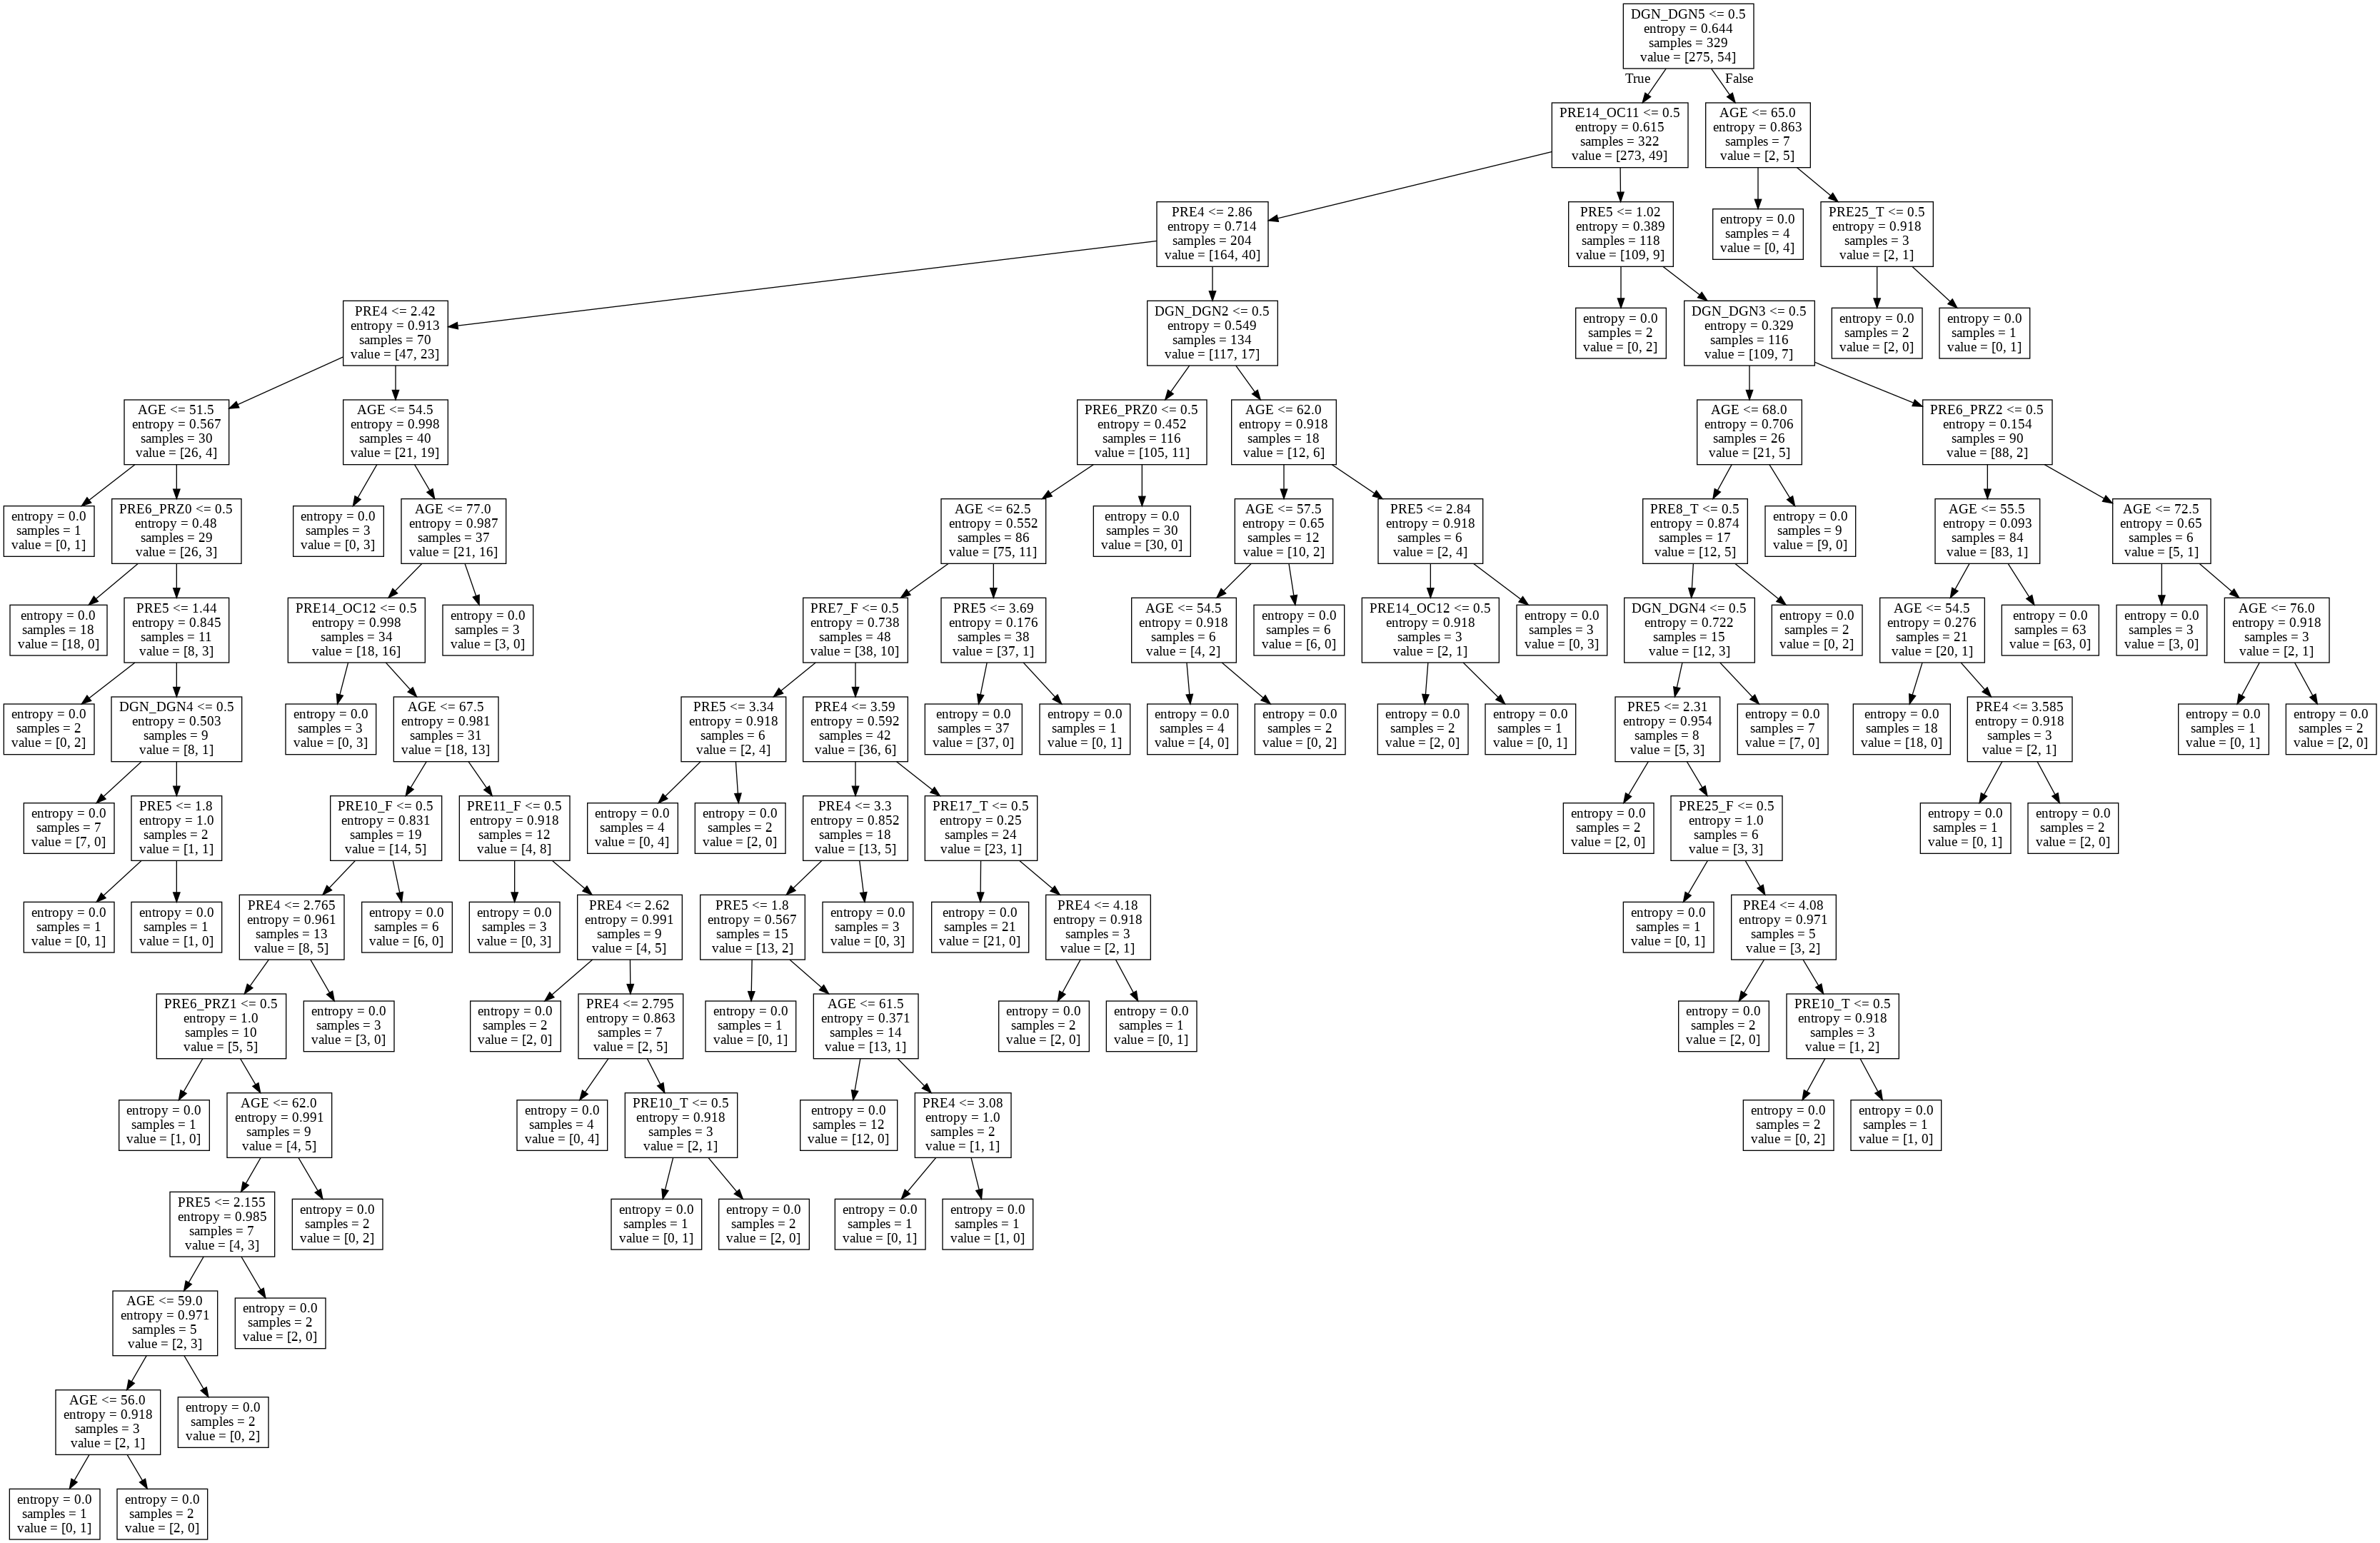

In [29]:
import graphviz
from IPython.display import Image
import pydotplus
graph2 = pydotplus.graph_from_dot_data(Vtree)
graph2
Image(graph2.create_png())
#graph2.write_png("gdrive/My Drive/ML_A2/Dtree.png")

# Basic KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knnC = KNeighborsClassifier(n_neighbors=5)
knnC.fit(xTrain, yTrain)
knnPred=knnC.predict(xTest)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(yTest, knnPred))

              precision    recall  f1-score   support

           0       0.83      0.58      0.68       119
           1       0.14      0.36      0.20        22

    accuracy                           0.55       141
   macro avg       0.48      0.47      0.44       141
weighted avg       0.72      0.55      0.61       141



In [32]:
#knn without oversampling
xTrainKnn,xTestKnn,yTrainKnn,yTestKnn=ms.train_test_split(X,Y,test_size=0.1)
knnC1 = KNeighborsClassifier(n_neighbors=5)
knnC1.fit(xTrainKnn,yTrainKnn)
knnPred1=knnC1.predict(xTestKnn)
print(classification_report(yTestKnn, knnPred1))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        37
           1       0.00      0.00      0.00        10

    accuracy                           0.79        47
   macro avg       0.39      0.50      0.44        47
weighted avg       0.62      0.79      0.69        47



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
from statistics import mean
from statistics import median
print('f1 avg_T: ',mean(scores_1))
print('f1 avg_F: ',mean(scores_0))
print('acc avg: ',mean(accs))

f1 avg_T:  0.28571428571428575
f1 avg_F:  0.875
acc avg:  0.7872340425531915


# Over view Result

![alt text](<a href="https://ibb.co/MsrQMfX"><img src="https://i.ibb.co/kxjvQJd/result.png" alt="result" border="0"></a>)
